## TCGA

## FPKM (Fragments Per Kilobase of transcript per Million)

When you have paired-end RNA-seq data, you count **fragments** (read pairs) rather than individual reads. FPKM normalizes for sequencing depth and gene length just like RPKM, but uses fragments.

1. **Sequencing depth**: samples sequenced to different depths get scaled so total fragment count differences don’t bias comparisons.  
2. **Gene length**: longer transcripts produce more fragments just by being longer, so we divide out transcript length.

The normalized \((i, j)\) FPKM value, where \(i\) is a gene and \(j\) is a sample, can be written two ways:

$$
\mathrm{FPKM}_{i,j}
=
\frac{f_{i,j}}
     {\,l_i \cdot \sum_{k} f_{k,j}\,}
\times 10^6
$$

or equivalently

$$
\mathrm{FPKM}_{i,j}
=
\frac{f_{i,j} \;\times\; 10^9}
     {\,N_j \;\times\; L_i\,}
$$

<!-- blank line above is important -->
- **\(f_{i,j}\)** is the raw fragment count for gene \(i\) in sample \(j\).  
- **\(l_i\)** is the length of gene \(i\) in kilobases (kb).  
- **\(\sum_{k} f_{k,j}\)** is the total number of fragments in sample \(j\).  
- **\(N_j\)** is the total fragments sequenced in sample \(j\).  
- **\(L_i\)** is the length of gene \(i\) in bases.  


In [2]:
import pandas as pd
import numpy as np

# mRna Seq
# Expression Data with gene as index and samples as columns
data_mrna_seq_rpkm = pd.read_csv('tcga_data/data_mrna_seq_fpkm.txt',
                    sep = '\t',
                    comment = '#')

data_mrna_seq_rpkm.set_index('Hugo_Symbol',inplace=True)

# Merge with mean duplicated rows
data_mrna_seq_rpkm = data_mrna_seq_rpkm.groupby(data_mrna_seq_rpkm.index).mean()

In [3]:
data_mrna_seq_rpkm.head()

,SP89389,SP21193,SP13206,SP103623,SP32742,SP111095,SP8394,SP87446,SP36586,SP123902,...,SP15656,SP123888,SP59420,SP116679,SP1377,SP16269,SP122676,SP88776,SP64546,SP21057
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
CRIPTOP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A1BG,0.409799,0.022891,0.082842,0.075852,0.149032,0.023175,0.119738,0.112135,0.059707,0.021957,...,0.587783,0.029553,0.229903,0.315114,0.034723,0.656322,0.476527,0.079750,0.091196,0.013030
A1BG-AS1,1.567399,0.196993,0.376265,0.271986,1.035252,0.132957,1.357942,0.753626,0.102765,0.110224,...,3.424922,0.378225,1.741374,1.946055,0.946255,3.781337,1.074688,0.554893,0.433442,0.074755
A1CF,0.043229,0.885682,0.000000,0.715912,0.010971,2.296044,0.027879,0.000000,1.656342,0.016029,...,0.049806,0.004742,0.008621,0.013397,0.000000,0.012708,0.000000,0.000708,0.001492,3.038471
A2M,30.816782,57.959083,37.798822,224.339366,23.396122,14.215019,53.002411,47.629206,51.087998,39.520998,...,0.023052,33.442775,53.716981,80.680141,23.491400,0.048657,121.201090,41.204146,33.427796,28.183744


In [5]:
# Mutations matrix
# Data telling which sample has a mutation in TP53 and the actual mutation
mutations= pd.read_csv('tcga_data/mutations.txt',
                    sep = '\t',
                    comment = '#')
mutations.set_index('SAMPLE_ID',inplace=True)

mutations.head()

,STUDY_ID,TP53
SAMPLE_ID,,
SP107436,pancan_pcawg_2020,WT
SP107435,pancan_pcawg_2020,WT
SP107407,pancan_pcawg_2020,WT
SP107406,pancan_pcawg_2020,WT
SP107405,pancan_pcawg_2020,WT


## Class balance check

We check how many samples are in each class before training, because if one class is much larger the model can become biased toward it. A balanced dataset helps the model learn to recognize both classes equally.

In [6]:
wt_count = 0
mut_count = 0

for mut_type in mutations['TP53']:
    if mut_type  == 'WT':
        wt_count += 1
    else:
        mut_count += 1

print(f"Number of WTs: {wt_count}")
print(f"Number of mutated: {mut_count}")

Number of WTs: 1781
Number of mutated: 902


There are almost twice as many mutated samples as WT. This imbalance may cause the model to overpredict the mutated class. To address it, we can:

- Use class weights in the loss function  
- Oversample the WT class or undersample the mutated class  
- Use techniques like SMOTE to generate synthetic WT examples  


In [7]:
# Transpose the data matrix, necessary to build the classifier
data_t = data_mrna_seq_rpkm.T

data_t.head()

Hugo_Symbol,CRIPTOP1,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A2MP1,...,snoZ178,snoZ185,snoZ247,snoZ278,snoZ40,snoZ5,snoZ6,snosnR60_Z15,snosnR66,yR211F11.2
SP89389,0.0,0.409799,1.567399,0.043229,30.816782,0.293354,0.312641,0.000000,0.146655,0.024311,...,0.0,0.0,0.0,0.0,0.0,12.87572,0.085771,0.0,0.0,0.000000
SP21193,0.0,0.022891,0.196993,0.885682,57.959083,0.125789,0.006278,0.000000,0.059391,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000
SP13206,0.0,0.082842,0.376265,0.000000,37.798822,0.056904,1.130378,0.000000,0.035823,0.026723,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000
SP103623,0.0,0.075852,0.271986,0.715912,224.339366,1.493611,0.114422,0.000000,0.000000,0.179434,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000
SP32742,0.0,0.149032,1.035252,0.010971,23.396122,0.235518,29.877306,0.051798,0.030327,0.045247,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.156084,0.0,0.0,0.020183


In [8]:
# Target vector
y = []

# Data matrix
X_rows = []
sample_names = []

c = 0
# Iterate over each mutation record to build the data matrix
for sample_id, mut_type in mutations['TP53'].items():
    if sample_id in data_t.index:
        # grab the full row from data_t and store it
        X_rows.append(data_t.loc[sample_id].values)
        y.append(0 if mut_type == 'WT' else 1)
        sample_names.append(sample_id)
    else:
        c += 1

X = pd.DataFrame(
    X_rows,
    index=sample_names,
    columns=data_t.columns
)
y = np.array(y)

print(f"Number of samples discarded: {c}")
print(f"Final number of samples available: {X.shape[0]}")

Number of samples discarded: 1692
Final number of samples available: 991


In [9]:
# Make sure X and y shape match
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (991, 55851)
y shape: (991,)


## Train - Test split (90% - 10%)
Because of data scarcity, we decided to reduce the test size to 10%

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y,
    test_size=0.1,
    random_state=42,
    stratify=y
)

print(f"Train shape:\n\tX_train: {X_train_np.shape}\n\ty_train: {y_train_np.shape}")
print(f"Test shape:\n\tX_test: {X_test_np.shape}\n\ty_test: {y_test_np.shape}")

Train shape:
	X_train: (891, 55851)
	y_train: (891,)
Test shape:
	X_test: (100, 55851)
	y_test: (100,)


## Model selection and Training

In [12]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,        # full depth
    random_state=42,
    n_jobs=-1              # use all cores
)

In [13]:
# Train
rf.fit(X_train_np, y_train_np)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [14]:
# Predict
y_pred = rf.predict(X_test_np)

## Evaluation metrics

**Accuracy**: the fraction of total samples correctly predicted (both WT and mutated). Good for a quick overview.  

In [15]:
from sklearn.metrics import accuracy_score

# y_test_np are your true labels 
# y_pred your predictions
acc = accuracy_score(y_test_np, y_pred)
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 83.00%


**Precision**: positive predictive value.  
$$
    \text{Precision} = \tfrac{\text{TP}}{\text{TP} + \text{FP}}
$$
**TP**: True Positive  
**FP**: False Positive 

In [16]:
from sklearn.metrics import precision_score

# y_test_np is your true labels array
# y_pred is your predicted labels
prec = precision_score(y_test_np, y_pred)
print(f'Precision: {prec*100:.2f}%')

Precision: 96.15%


**Recall**: the fraction of actual mutated samples the model correctly identified, good for understanding how many real mutations you catch.  
$$
  \text{Recall} = \tfrac{\text{TP}}{\text{TP} + \text{FN}}
$$
**TP**: True Positive  
**FP**: False Negative 

In [17]:
from sklearn.metrics import recall_score

# y_test_np is your true labels array
# y_pred is your predicted labels
rec = recall_score(y_test_np, y_pred)
print(f'Recall: {rec*100:.2f}%')

Recall: 60.98%


**F1 score**: the harmonic mean of precision and recall, good for balancing false positives and false negatives.

In [18]:
from sklearn.metrics import f1_score

# y_test_np is your true labels array, y_pred your predicted labels
f1 = f1_score(y_test_np, y_pred)
print(f'F1 score: {f1*100:.2f}%')

F1 score: 74.63%


**Confusion matrix**: a table of
* **True Positives** (TP): mutated correctly called mutated
* **True Negatives** (TN): WT correctly called WT
* **False Positives** (FP): WT called mutated
* **False Negatives** (FN): mutated called WT

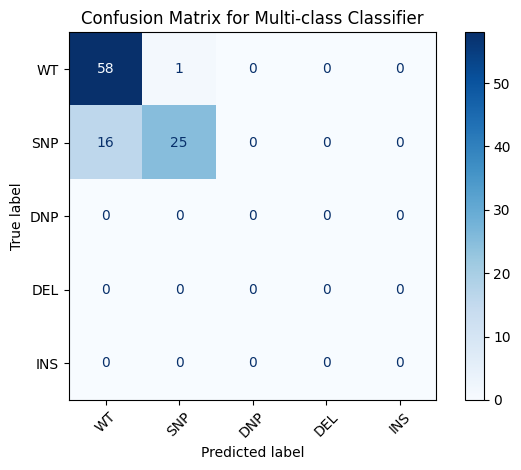

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix for all five classes
cm = confusion_matrix(y_test_np, y_pred, labels=[0,1,2,3,4])

# Define the class names in the same order as their codes
class_names = ['WT', 'SNP', 'DNP', 'DEL', 'INS']

# Create and plot the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

plt.xticks(rotation=45)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Multi-class Classifier')
plt.tight_layout()
plt.show()
